In [ ]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.4 MB/s eta 0:00:00


Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL). PLEASE USE APPROPRIATE PATH TO TASK
2

In [ ]:
#set title for saving model
title = "seb_vs_nev&mel_no_aug"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

Initialize the ViT model

In [ ]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Add additional layer to the ViT model

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [ ]:
#Function for finding focal loss
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Compile the model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8) #Configure early stopping criteria

#Function for dynamic learning rate
def step_decay(epoch):
    initial_lrate = 0.00002
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [ ]:
#Function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


Function for eavaluation of model

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()



    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)   #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')  #Calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [ ]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [ ]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [ ]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.5111
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_1.hdf5
18/18 [==============================] - 98s 1s/step - loss: 0.2535 - accuracy: 0.5111 - val_loss: 0.0523 - val_accuracy: 0.7200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.5500
Epoch 2: val_accuracy did not improve from 0.72000
18/18 [==============================] - 10s 573ms/step - loss: 0.1857 - accuracy: 0.5500 - val_loss: 0.1045 - val_accuracy: 0.6400 - lr

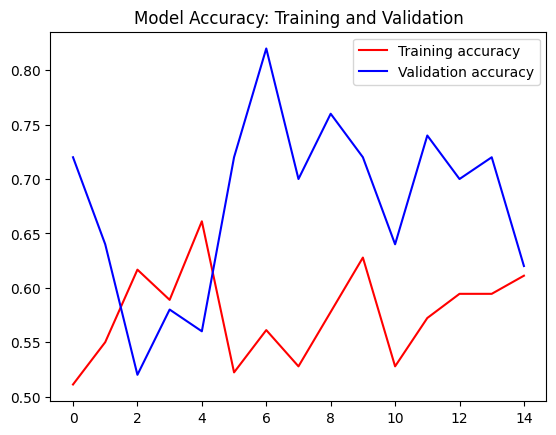

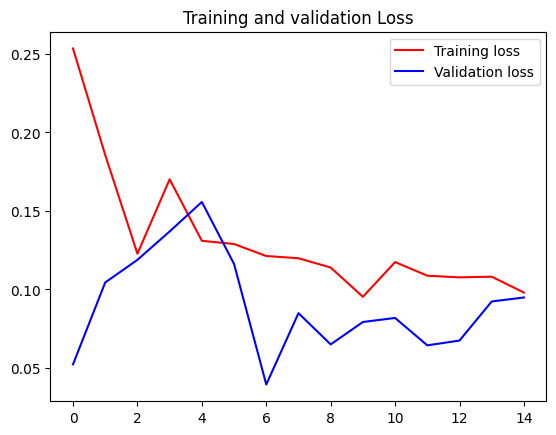

<Figure size 640x480 with 0 Axes>

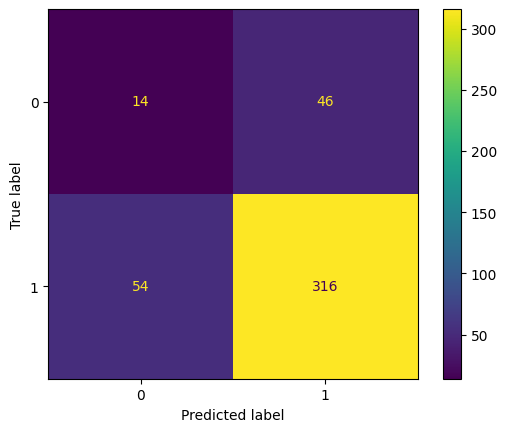


               precision    recall  f1-score   support

           0       0.21      0.23      0.22        60
           1       0.87      0.85      0.86       370

    accuracy                           0.77       430
   macro avg       0.54      0.54      0.54       430
weighted avg       0.78      0.77      0.77       430

Sensitivity: 0.854 Specificity: 0.233 Precision: 0.78 ROC_AUC_SCORE: 0.595



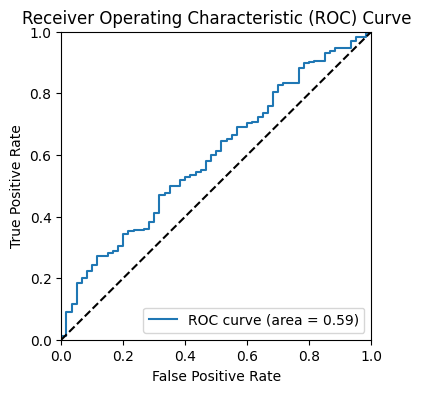

Validation complete...
Traning for Fold: 2
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.5667
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_2.hdf5
18/18 [==============================] - 67s 987ms/step - loss: 0.1208 - accuracy: 0.5667 - val_loss: 0.0702 - val_accuracy: 0.7600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.5833
Epoch 2: val_accuracy did not improve from 0.76000
18/18 [==============================] - 9s 497ms/step - loss: 0.1219 - accuracy: 0.5833 - val_loss: 0.0485 - 

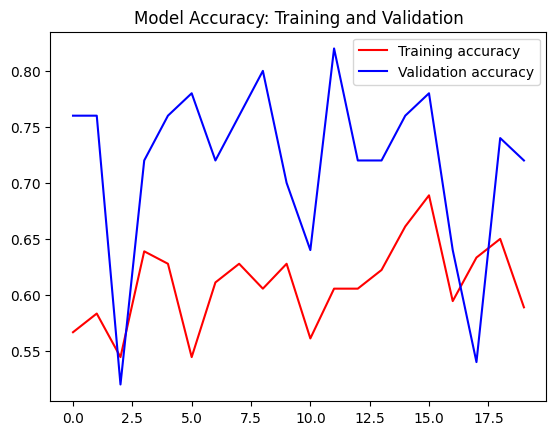

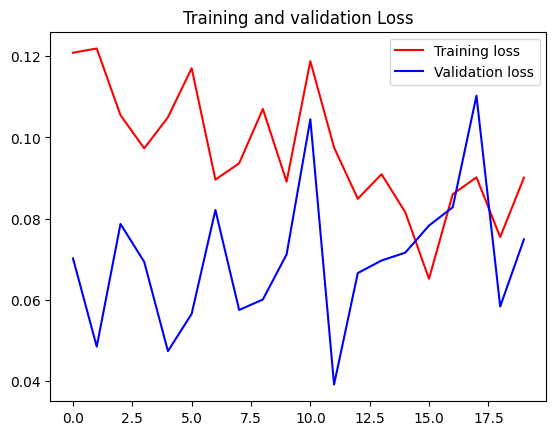

<Figure size 640x480 with 0 Axes>

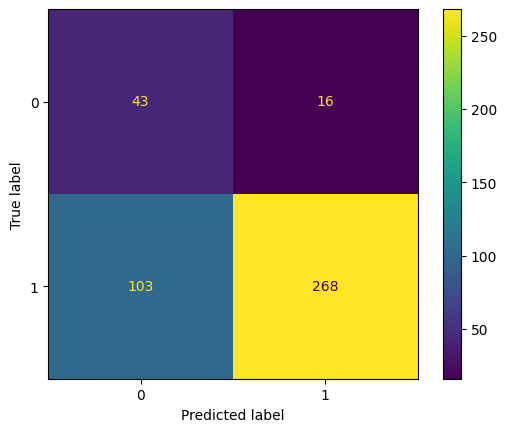


               precision    recall  f1-score   support

           0       0.29      0.73      0.42        59
           1       0.94      0.72      0.82       371

    accuracy                           0.72       430
   macro avg       0.62      0.73      0.62       430
weighted avg       0.85      0.72      0.76       430

Sensitivity: 0.722 Specificity: 0.729 Precision: 0.855 ROC_AUC_SCORE: 0.784



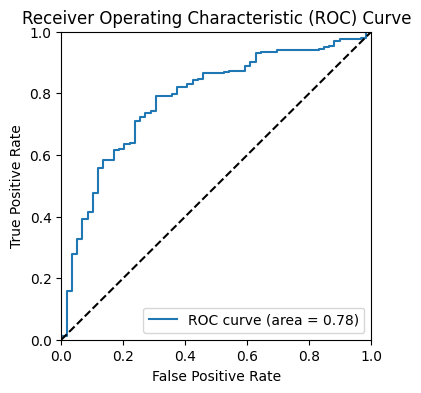

Validation complete...
Traning for Fold: 3
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.5667
Epoch 1: val_accuracy improved from -inf to 0.66000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_3.hdf5
18/18 [==============================] - 68s 1s/step - loss: 0.0973 - accuracy: 0.5667 - val_loss: 0.0817 - val_accuracy: 0.6600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.6167
Epoch 2: val_accuracy improved from 0.66000 to 0.78000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_3.hdf5
18/18 [====

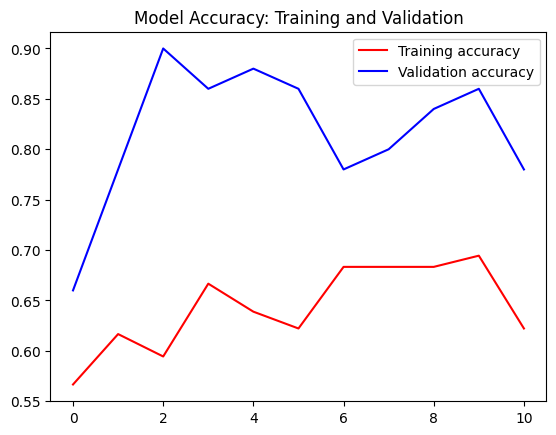

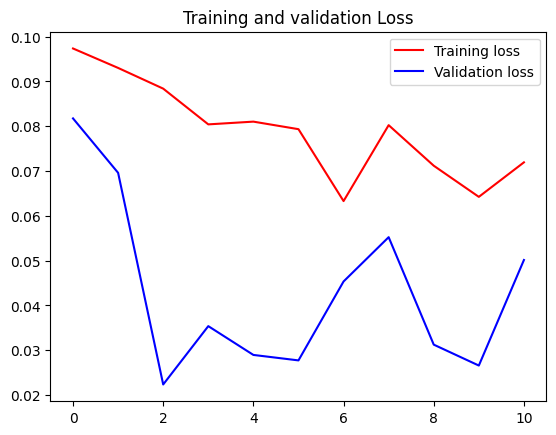

<Figure size 640x480 with 0 Axes>

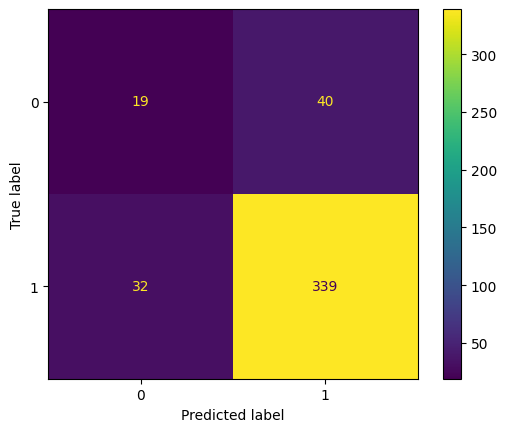


               precision    recall  f1-score   support

           0       0.37      0.32      0.35        59
           1       0.89      0.91      0.90       371

    accuracy                           0.83       430
   macro avg       0.63      0.62      0.62       430
weighted avg       0.82      0.83      0.83       430

Sensitivity: 0.914 Specificity: 0.322 Precision: 0.823 ROC_AUC_SCORE: 0.763



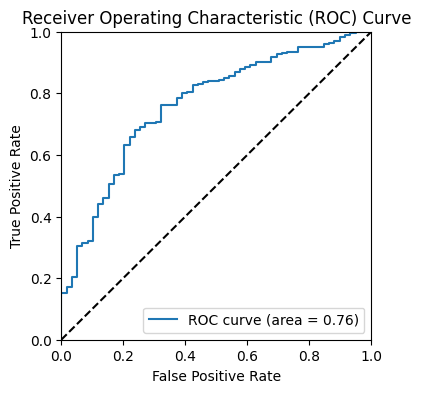

Validation complete...
Traning for Fold: 4
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.5722
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_4.hdf5
18/18 [==============================] - 71s 1s/step - loss: 0.0835 - accuracy: 0.5722 - val_loss: 0.0440 - val_accuracy: 0.7600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.5722
Epoch 2: val_accuracy improved from 0.76000 to 0.90000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_4.hdf5
18/18 [====

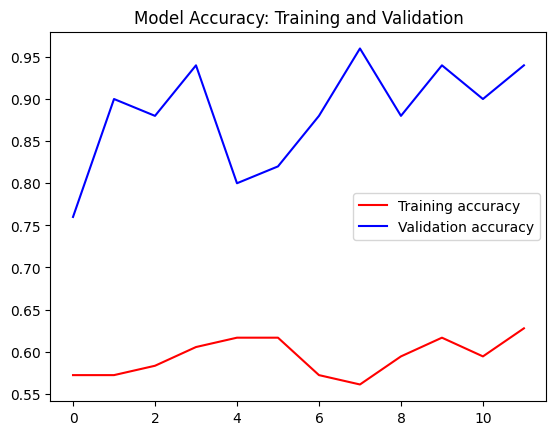

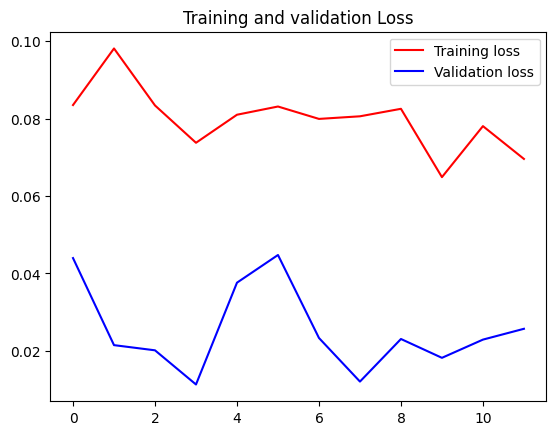

<Figure size 640x480 with 0 Axes>

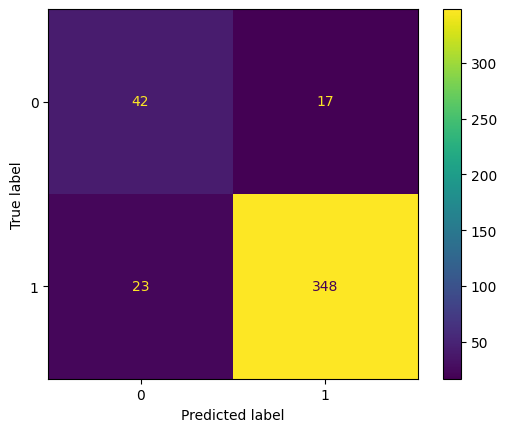


               precision    recall  f1-score   support

           0       0.65      0.71      0.68        59
           1       0.95      0.94      0.95       371

    accuracy                           0.91       430
   macro avg       0.80      0.82      0.81       430
weighted avg       0.91      0.91      0.91       430

Sensitivity: 0.938 Specificity: 0.712 Precision: 0.911 ROC_AUC_SCORE: 0.912



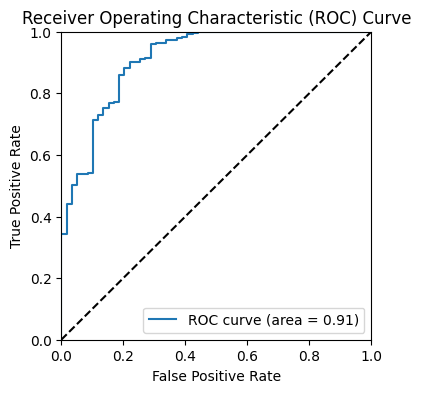

Validation complete...
Traning for Fold: 5
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.5944
Epoch 1: val_accuracy improved from -inf to 0.98000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_no_aug/model_fold_5.hdf5
18/18 [==============================] - 71s 1s/step - loss: 0.0836 - accuracy: 0.5944 - val_loss: 0.0129 - val_accuracy: 0.9800 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.6389
Epoch 2: val_accuracy did not improve from 0.98000
18/18 [==============================] - 9s 526ms/step - loss: 0.0775 - accuracy: 0.6389 - val_loss: 0.0075 - val

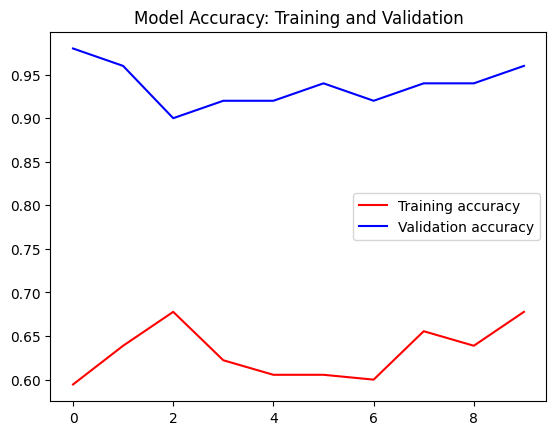

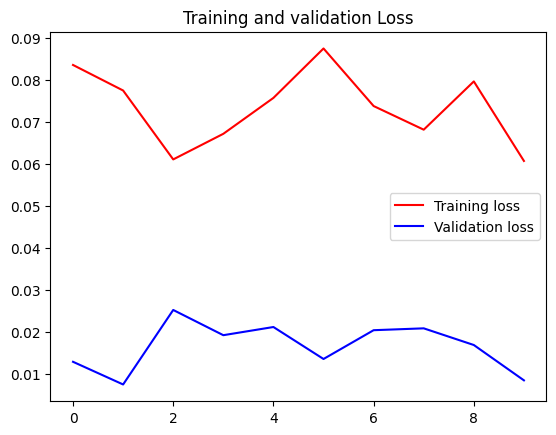

<Figure size 640x480 with 0 Axes>

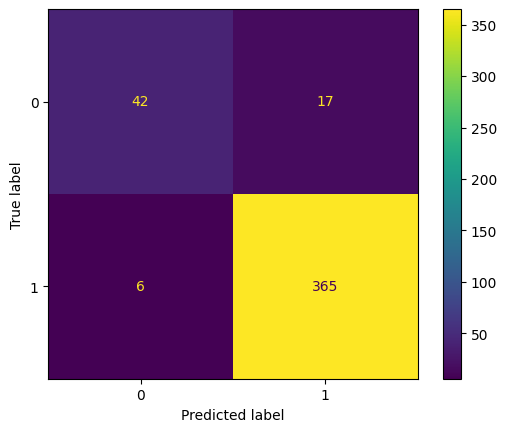


               precision    recall  f1-score   support

           0       0.88      0.71      0.79        59
           1       0.96      0.98      0.97       371

    accuracy                           0.95       430
   macro avg       0.92      0.85      0.88       430
weighted avg       0.94      0.95      0.94       430

Sensitivity: 0.984 Specificity: 0.712 Precision: 0.944 ROC_AUC_SCORE: 0.954



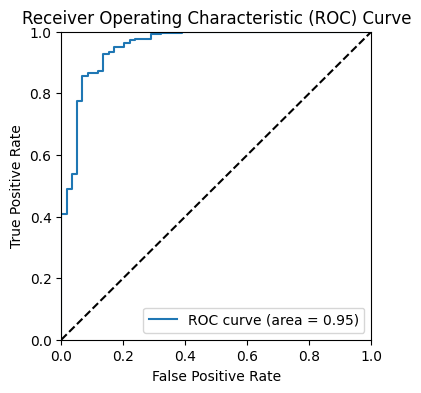

Validation complete...


In [ ]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    #Use this validation data for evaluating results in each fold with shuffle = false
    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)

    # Evaluate the model on the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


Test using model 1
600/600 [==============================] - 43s 72ms/step


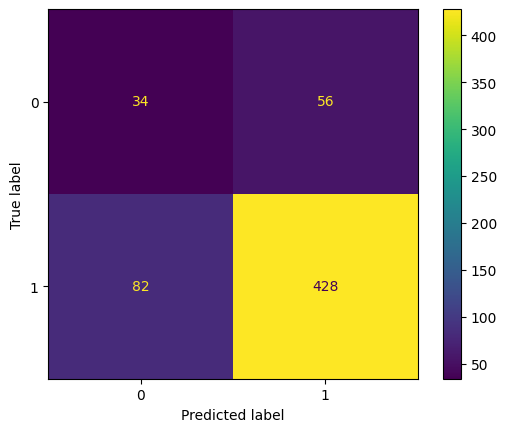


               precision    recall  f1-score   support

           0       0.29      0.38      0.33        90
           1       0.88      0.84      0.86       510

    accuracy                           0.77       600
   macro avg       0.59      0.61      0.60       600
weighted avg       0.80      0.77      0.78       600

Sensitivity: 0.839 Specificity: 0.378 Precision: 0.796 ROC_AUC_SCORE: 0.699



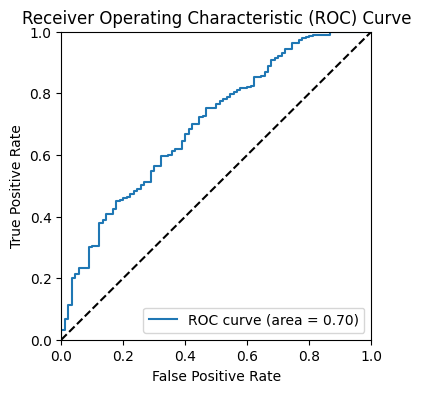

Testing Complete
Test using model 2
600/600 [==============================] - 25s 42ms/step


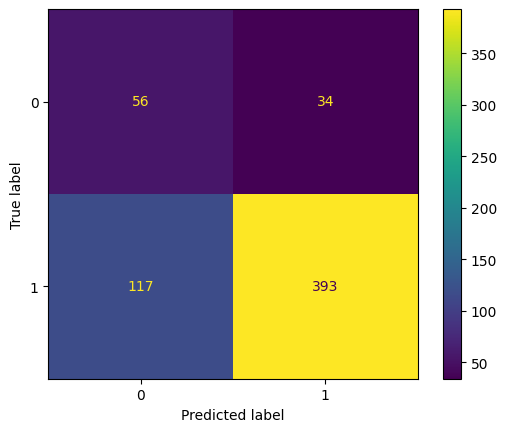


               precision    recall  f1-score   support

           0       0.32      0.62      0.43        90
           1       0.92      0.77      0.84       510

    accuracy                           0.75       600
   macro avg       0.62      0.70      0.63       600
weighted avg       0.83      0.75      0.78       600

Sensitivity: 0.771 Specificity: 0.622 Precision: 0.831 ROC_AUC_SCORE: 0.769



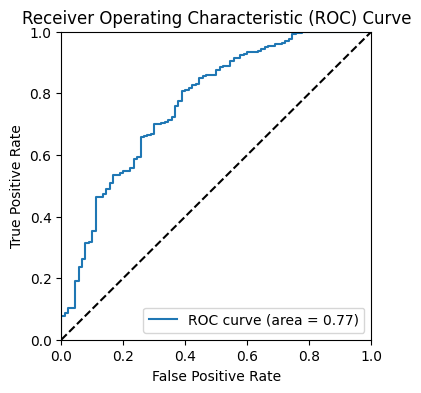

Testing Complete
Test using model 3
600/600 [==============================] - 26s 43ms/step


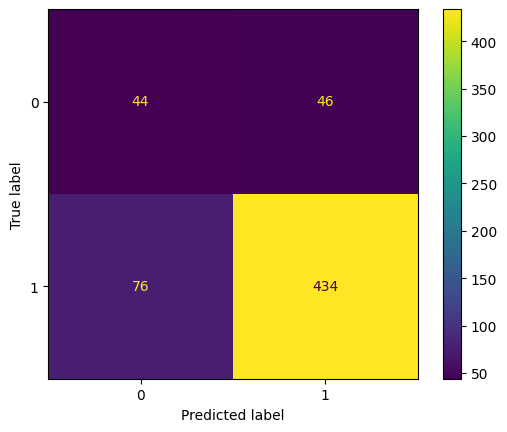


               precision    recall  f1-score   support

           0       0.37      0.49      0.42        90
           1       0.90      0.85      0.88       510

    accuracy                           0.80       600
   macro avg       0.64      0.67      0.65       600
weighted avg       0.82      0.80      0.81       600

Sensitivity: 0.851 Specificity: 0.489 Precision: 0.824 ROC_AUC_SCORE: 0.739



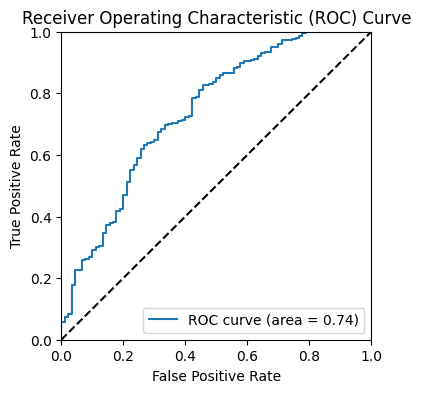

Testing Complete
Test using model 4
600/600 [==============================] - 29s 49ms/step


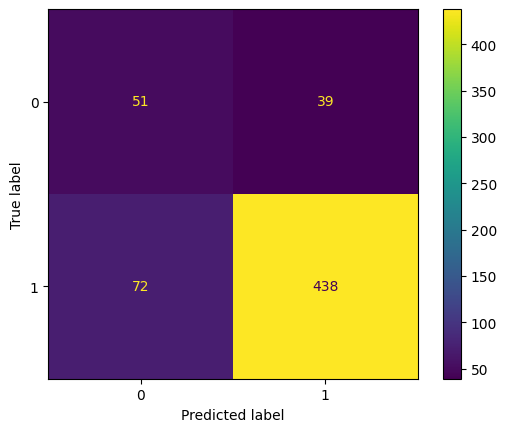


               precision    recall  f1-score   support

           0       0.41      0.57      0.48        90
           1       0.92      0.86      0.89       510

    accuracy                           0.81       600
   macro avg       0.67      0.71      0.68       600
weighted avg       0.84      0.81      0.83       600

Sensitivity: 0.859 Specificity: 0.567 Precision: 0.843 ROC_AUC_SCORE: 0.801



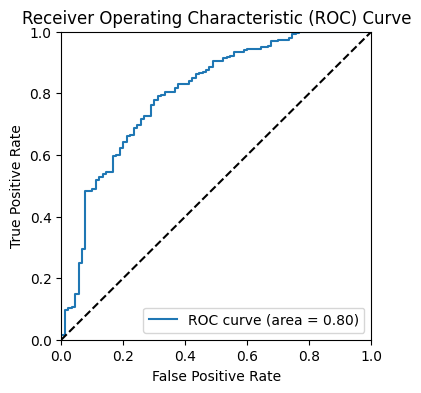

Testing Complete
Test using model 5
600/600 [==============================] - 26s 44ms/step


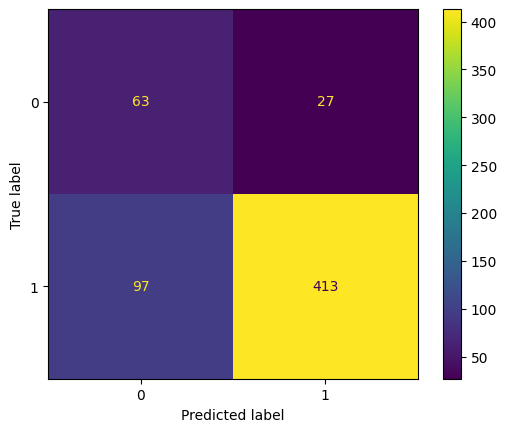


               precision    recall  f1-score   support

           0       0.39      0.70      0.50        90
           1       0.94      0.81      0.87       510

    accuracy                           0.79       600
   macro avg       0.67      0.75      0.69       600
weighted avg       0.86      0.79      0.81       600

Sensitivity: 0.81 Specificity: 0.7 Precision: 0.857 ROC_AUC_SCORE: 0.831



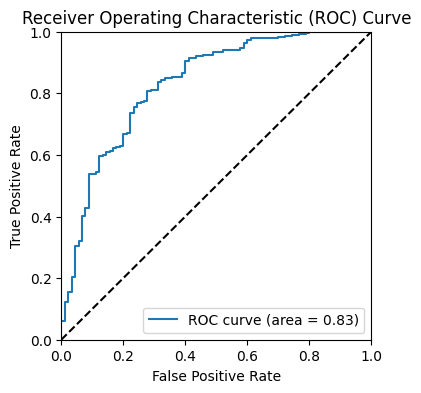

Testing Complete


In [ ]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")